In [1]:
import operator
from pprint import pprint
import itertools
import re
import numpy as np

from SolrClient import SolrClient

import gensim
from gensim.models import CoherenceModel, LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import matutils

import pyLDAvis.gensim

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
%matplotlib inline

D:\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
pyLDAvis.enable_notebook()

In [3]:
solr = SolrClient('http://192.168.200.112:8983')

In [13]:
query_def = {
            'q': '-ctr_id:id_document_spell',
            'indent': 'true',
            'fl': 'ctr_id,ctr_content_nlp',
            'wt': 'json',
            'rows': '2147483647'
            }

In [14]:
res = solr.query('default',query_def)

In [15]:
res.get_results_count()

34650

In [16]:
def process_texts(docs, text_fields, language='portuguese'):
    """
    Function to process texts. Following are the steps we take:

    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).

    Parameters:
    ----------
    texts: Tokenized texts.

    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    texts = []
    for doc in docs:
        text = None
        for text_field in text_fields:
            if text_field in doc:
                text = gensim.utils.simple_preprocess(doc[text_field], deacc=False, min_len=3)
                texts.append(text)
    stops = set(stopwords.words(language))
    texts = [[word for word in text if word not in stops] for text in texts]
    
    phrases = gensim.models.Phrases(texts)
    bigram = gensim.models.phrases.Phraser(phrases)
    
    for idx in range(len(texts)):
        for token in bigram[texts[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                texts[idx].append(token)
    
    return texts

In [17]:
%%time
train_texts = process_texts(res.docs, ['ctr_content_nlp'])

Wall time: 39.6 s


In [18]:
len(train_texts)

34650

In [19]:
str(train_texts[0])

"['sexta', 'feira', 'abril', 'paulo', 'transporte', 'relatório', 'administração', 'introdução', 'yhtfxorv', 'fxmd', 'pdwul', 'paulo', 'transporte', 'sptrans', 'empresa', 'yldjhqv', 'hqwuh', 'fduuhjdphqwrv', 'gdv', 'gdv', 'uhghv', 'municipal', 'transportes', 'smt', 'março', 'qhfhvvlgdgh', 'lpsodqwdomr', 'whuplqdo', 'whuplqdo', 'pxqlflsdo', 'cessora', 'cmtc', 'sruwh', 'ppglr', 'qdo', 'ldghpd', 'urrnolq', 'uhvsrqviyho', 'shor', 'jhuhqfldphqwr', 'vfdol', 'domr', 'ghvhqyroylgrv', 'hvwxgrv', 'vhqwlgr', 'lghqwl', 'xpd', 'iuhd', 'sdud', 'vxd', 'participação', 'cidade', 'são_paulo', 'paulo', 'implantar', 'determinar', 'remhwlyr', 'dwxdol', 'frqkhflphqwrv', 'informação', 'metrô', 'estação', 'vila', 'sônia', 'quilômetro', 'redução', 'porte', 'terminal', 'brasilândia', 'rpr', 'irudp', 'lqiru', 'yldelol', 'fdomr', 'rxwur', 'vxd', 'mações', 'sistema', 'rede', 'linha', 'ônibus', 'plantação', 'sptrans', 'emtu', 'trem', 'cptm', 'metrô', 'ano', 'sptrans', 'metrô', 'sentido', 'frpr', 'rqwh', 'uhihurqfld'

In [20]:
dictionary = Dictionary(train_texts)

In [21]:
print('Number of unique tokens: %d' % len(dictionary))

Number of unique tokens: 160525


In [22]:
dictionary.save('mp_dictionary_full.dict')

In [23]:
dictionary_filtered = Dictionary(train_texts)
dictionary_filtered.save('mp_dictionary_filtered.dict')
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.5)
dictionary_filtered.filter_extremes(no_above=0.5)
print('Number of unique tokens: %d' % len(dictionary_filtered))

Number of unique tokens: 43682


In [24]:
corpus = [dictionary.doc2bow(text) for text in train_texts]
print('Number of documents on full: %d' % len(corpus))
corpus_filtered = [dictionary_filtered.doc2bow(text) for text in train_texts]
print('Number of documents on filtered: %d' % len(corpus_filtered))

Number of documents on full: 34650
Number of documents on filtered: 34650


In [26]:
%%time
ldamodel_filtered = LdaModel(corpus=corpus_filtered, num_topics=100, id2word=dictionary_filtered, chunksize=8000, passes=20, iterations=400, eval_every=None, alpha='auto', eta='auto')

Wall time: 41min 1s


In [27]:
pyLDAvis.gensim.prepare(ldamodel_filtered, corpus_filtered, dictionary_filtered)

D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
77     5.954765        1       1 -0.076317  0.072801
83     5.090398        1       2 -0.068757  0.226051
39     4.190679        1       3 -0.109222  0.107506
52     4.042261        1       4 -0.116245  0.052352
21     3.092942        1       5  0.119908 -0.017495
24     2.950613        1       6 -0.175576  0.174793
30     2.879056        1       7 -0.014694  0.255312
64     2.788591        1       8 -0.305385 -0.179186
14     2.658365        1       9 -0.278729 -0.155324
38     2.215009        1      10 -0.072068  0.158315
55     2.086787        1      11 -0.107295  0.157371
1      1.990232        1      12  0.016007  0.202206
4      1.961723        1      13 -0.110651  0.152837
51     1.917965        1      14 -0.214145  0.044503
98     1.890301        1      15 -0.085570  0.075234
2      1.710822        1      16 -0.238579 -0.120655
93     1.573058        1      17  0.103096  0.041306
84     1.506069        1      18 -0.098604  0.040624
45     1.329733        1      19  0.049757  0.192395
32     1.312918        1      20  0.012548  0.171334
95     1.288104        1      21 -0.260417 -0.167735
9      1.255838        1      22  0.042723 -0.023928
40     1.239313        1      23 -0.022695  0.053524
47     1.232832        1      24 -0.155575  0.008463
3      1.207481        1      25 -0.168539  0.057980
63     1.198287        1      26 -0.093288  0.053601
19     1.194109        1      27 -0.031688  0.099278
42     1.192167        1      28  0.086115  0.155004
22     1.139763        1      29 -0.198599 -0.089986
7      1.139647        1      30 -0.110900  0.152456
...         ...      ...     ...       ...       ...
59     0.437628        1      71  0.085445 -0.056057
28     0.435939        1      72  0.104506 -0.043116
31     0.407615        1      73  0.136834  0.031313
50     0.406970        1      74  0.114788 -0.049310
48     0.388517        1      75  0.118903 -0.055891
34     0.373174        1      76  0.051573  0.016305
99     0.372993        1      77  0.080692 -0.053461
43     0.364614        1      78  0.086704 -0.032717
87     0.357548        1      79  0.094029 -0.048280
89     0.356907        1      80  0.122974 -0.077017
29     0.354930        1      81 -0.004708  0.000592
18     0.344860        1      82  0.030083 -0.037395
97     0.344641        1      83  0.089327 -0.050440
67     0.336350        1      84  0.089743 -0.040100
81     0.331046        1      85  0.117136 -0.038264
91     0.327728        1      86  0.068370 -0.014009
85     0.321365        1      87  0.043849 -0.045821
88     0.312573        1      88  0.000317 -0.026083
37     0.298510        1      89 -0.071726 -0.133215
92     0.286534        1      90  0.107046 -0.058654
90     0.274583        1      91  0.057300 -0.085660
66     0.272661        1      92  0.073147 -0.069231
13     0.270760        1      93  0.111018 -0.079275
10     0.259493        1      94  0.066867 -0.040131
35     0.255667        1      95  0.082956 -0.032322
0      0.252549        1      96  0.114652 -0.073336
76     0.246266        1      97  0.098600 -0.073063
54     0.216787        1      98  0.082459 -0.075127
58     0.213726        1      99  0.097431 -0.085294
12     0.205740        1     100  0.118328 -0.073768

[100 rows x 5 columns], topic_info=       Category          Freq                       Term         Total  \
term                                                                     
481     Default  31033.000000                        art  31033.000000   
521     Default  24302.000000                       ltda  24302.000000   
252     Default  32282.000000                      valor  32282.000000   
230     Default  32345.000000                     estado  32345.000000   
482     Default  28818.000000                        lei  28818.000000   
624     Default  20675.000000                       item  20675.000000   
76

In [ ]:
%%time
coherence_model = CoherenceModel(model=ldamodel_filtered, texts=train_texts, dictionary=dictionary_filtered, coherence='c_v')
coherence_model.get_coherence()

In [ ]:
print('test')

In [42]:
%%time
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [44]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
9      16.062164        1       1  0.108215  0.011378
2      14.481221        1       2  0.123531 -0.125205
7      13.614325        1       3  0.099705  0.155201
3      12.106763        1       4 -0.233736  0.194356
5      10.676494        1       5  0.140938  0.057607
4      10.478044        1       6  0.088598 -0.031187
8       7.046157        1       7 -0.093317 -0.127232
6       6.477050        1       8  0.002912  0.132431
0       6.442281        1       9  0.109609 -0.144826
1       2.615500        1      10 -0.346455 -0.122524, topic_info=       Category           Freq            Term          Total  loglift  \
term                                                                     
4       Default   92317.000000         direito   92317.000000  30.0000   
2840    Default   42279.000000            vara   42279.000000  29.0000   
1337    Default   36572.000000           cível   36572.000000  28.0000   
5274    Default   57020.000000        ministro   57020.000000  27.0000   
1819    Default   25200.000000         criança   25200.000000  26.0000   
1423    Default   64479.000000      judiciário   64479.000000  25.0000   
1156    Default   36677.000000            tjsp   36677.000000  24.0000   
500     Default  118060.000000         justiça  118060.000000  23.0000   
548     Default   35085.000000         empresa   35085.000000  22.0000   
153     Default   59061.000000      presidente   59061.000000  21.0000   
657     Default   38738.000000           valor   38738.000000  20.0000   
1233    Default   41907.000000           crime   41907.000000  19.0000   
1133    Default   98504.000000        tribunal   98504.000000  18.0000   
1135    Default   18937.000000          escola   18937.000000  17.0000   
6       Default   64095.000000             lei   64095.000000  16.0000   
1144    Default   30573.000000         polícia   30573.000000  15.0000   
2841    Default   22872.000000         comarca   22872.000000  14.0000   
2435    Default   63443.000000         decisão   63443.000000  13.0000   
1134    Default  120509.000000           paulo  120509.000000  12.0000   
545     Default   30849.000000         família   30849.000000  11.0000   
1854    Default   16618.000000        anterior   16618.000000  10.0000   
2875    Default   24967.000000           preso   24967.000000   9.0000   
3       Default   83198.000000            juiz   83198.000000   8.0000   
3136    Default   16199.000000        telefone   16199.000000   7.0000   
3928    Default   20290.000000        deputado   20290.000000   6.0000   
5950    Default   21118.000000        comarcar   21118.000000   5.0000   
1075    Default   12574.000000            mail   12574.000000   4.0000   
3800    Default   11983.000000             des   11983.000000   3.0000   
1303    Default   34726.000000        criminal   34726.000000   2.0000   
1874    Default   23082.000000        policial   23082.000000   1.0000   
...         ...            ...             ...            ...      ...   
3537    Topic10    6565.807322        endereço   11970.411871   3.0432   
3136    Topic10    8197.491223        telefone   16199.186232   2.9626   
58489   Topic10    2166.050416  apadrinhamento    3135.975798   3.2737   
3575    Topic10    2215.533320             dje    3253.163194   3.2596   
1854    Topic10    8006.905816        anterior   16618.811830   2.9135   
1103    Topic10    2206.265057      certificar    3473.999616   3.1897   
3566    Topic10    1959.114437      selecionar    3003.302149   3.2165   
17582   Topic10    3349.687008   telefone_mail    6484.205893   2.9832   
123422  Topic10    1185.210946  prejuízo_varar    1502.730282   3.4064   
4495    Topic10    2175.626268       endereçar    3757.956135   3.0972   
162405  Topic10    3380.778770  página_externo    8047.478989   2.7765   
4       Topic10   15101.131825         direito   9231

In [49]:
np.arange(5, 105, 5)

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100])

In [31]:
def get_best_model_by_topics(dictionary, corpus, texts, limit, iterations=400):
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    # Set training parameters.
    chunksize = 4000
    passes = 20
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    
    lm_list = {}
    co_va = {}
    for num_topics in np.arange(5, limit, 5):
        lm = LdaModel(corpus=corpus, id2word=dictionary, passes=passes, \
                      num_topics=num_topics, chunksize=chunksize, iterations=iterations, \
                      eval_every=eval_every, alpha='auto', eta='auto')
        lm_list[num_topics - 1] = lm
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        co_va[num_topics - 1] = cm.get_coherence()
    top_models = sorted(co_va.items(), key=operator.itemgetter(1), reverse=True)
    print('Melhores 5 modelos', top_models[:5])
    return lm_list[top_models[0][0]], lm_list, co_va

In [ ]:
%%time
best_model_full, lm_full, c_v_full = get_best_model_by_topics(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=105)
print(best_model_full.show_topics(formatted=True))

In [25]:
%%time
best_model_filtered, lm_filtered, c_v_filtered = get_best_model_by_topics(dictionary=dictionary_filtered, corpus=corpus_filtered, texts=train_texts, limit=10)
print(best_model_filtered.show_topics(formatted=True))

/media/discoD/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(2, 0.77688571265045248), (5, 0.75743821734662553), (4, 0.75666620261812212), (3, 0.738450814171554), (6, 0.72722104639037488)]
[(0, '0.019*"art" + 0.007*"lei" + 0.007*"uso" + 0.007*"publicar" + 0.006*"federal" + 0.006*"resolver" + 0.006*"portar" + 0.006*"cargo" + 0.006*"código" + 0.005*"atribuição"'), (1, '0.014*"ltda" + 0.013*"valor" + 0.012*"cnpj" + 0.009*"item" + 0.009*"contratar" + 0.009*"total" + 0.008*"serviço" + 0.008*"contrato" + 0.008*"pregão" + 0.007*"lei"'), (2, '0.012*"uniformização" + 0.011*"turma" + 0.010*"federal" + 0.008*"nacional" + 0.008*"adv" + 0.008*"decisão" + 0.008*"proc" + 0.008*"requerente" + 0.008*"parte" + 0.007*"origem"')]
CPU times: user 12min 27s, sys: 4.56 s, total: 12min 32s
Wall time: 12min 38s


In [26]:
# Build topic listings from each model.
def top_topics(lda, num_words=20):
    str_topics = []
    for topic in lda.state.get_lambda():
        topic = topic / topic.sum()  # normalize to probability distribution
        bestn = matutils.argsort(topic, topn=num_words, reverse=True)
        beststr = [lda.id2word[_id] for _id in bestn]
        str_topics.append(beststr)
    return str_topics

def get_super_topic(trained_models):
    model_topics = {}
    super_topic = set()
    for num_topics, model in trained_models.items():
        topics_as_topn_terms = top_topics(model)
        model_topics[num_topics] = topics_as_topn_terms
        super_topic.update(itertools.chain.from_iterable(topics_as_topn_terms))
    print("Number of relevant terms: %d" % len(super_topic))
    return super_topic, model_topics

In [27]:
super_topic, model_topics = get_super_topic(lm_filtered)
print(super_topic)

Number of relevant terms: 187
{'portaria', 'tornar', 'número', 'vaga', 'bom', 'diário', 'cnpj', 'diretoria', 'juizado', 'pregão', 'prefeitura', 'informar', 'técnico', 'embargo', 'inscrição', 'sidec', 'universidade', 'segundo', 'recurso', 'cpf', 'ltda', 'seguinte', 'pregão_eletrônico', 'item', 'partir', 'epp', 'prova', 'eletrônico', 'matrícula', 'uso_atribuição', 'nacional', 'representação', 'valor', 'inciso', 'endereço', 'presidente', 'licitar', 'registro', 'oliveira', 'datar_assinatura', 'valor_total', 'contratante', 'proc_adv', 'presente', 'benefício', 'federal', 'multa', 'agravo', 'dia', 'documento', 'aquisição', 'inss', 'tnu', 'união', 'termo', 'vigência', 'licitar_edital', 'prazo', 'santo', 'empresa', 'conhecimento', 'informação', 'edital', 'ministro', 'proc', 'emissão', 'parte', 'total', 'caso', 'poder', 'sicon', 'engenharia', 'rdc', 'regimental', 'todo', 'art', 'meio', 'direito', 'real', 'setembro', 'cnpj_contratar', 'dispor', 'oab', 'artigo', 'fundamento_legal', 'total_item', '

In [28]:
%%time
# Now estimate the probabilities for the CoherenceModel

cm = CoherenceModel(
    topics=[super_topic], texts=train_texts,
    dictionary=dictionary_filtered, coherence='c_v')
cm.estimate_probabilities()

CPU times: user 256 ms, sys: 24 ms, total: 280 ms
Wall time: 3.62 s


In [29]:
cm.get_coherence_per_topic()

[0.37929283745741299]

In [32]:
%%time
import numpy as np
# Next we perform the coherence evaluation for each of the models.
# Since we have already precomputed the probabilities, this simply
# involves using the accumulated stats in the `CoherenceModel` to
# perform the evaluations, which should be pretty quick.

coherences = {}
for num_topics, topics in model_topics.items():
    cm.topics = topics

    # We evaluate at various values of N and average them. This is a more robust,
    # according to: http://people.eng.unimelb.edu.au/tbaldwin/pubs/naacl2016.pdf
    coherence_at_n = {}
    for n in (20, 15, 10, 5):
        cm.topn = n
        topic_coherences = cm.get_coherence_per_topic()
        #print('coherence per topic for', n, 'topics', topic_coherences)
        
        # Let's record the coherences for each topic, as well as the aggregated
        # coherence across all of the topics.
        coherence_at_n[n] = (topic_coherences, cm.aggregate_measures(topic_coherences))
        #print('coherence at', n, 'topics', cm.aggregate_measures(topic_coherences))
        
    topic_coherences, avg_coherences = zip(*coherence_at_n.values())
    avg_topic_coherences = np.vstack(topic_coherences).mean(0)
    avg_coherence = np.mean(avg_coherences)
    print("Avg coherence for num_topics=%d: %.5f" % (num_topics, avg_coherence))
    coherences[num_topics] = (avg_topic_coherences, avg_coherence)

Avg coherence for num_topics=0: 0.40415
Avg coherence for num_topics=1: 0.42270
Avg coherence for num_topics=2: 0.74717
Avg coherence for num_topics=3: 0.66390
Avg coherence for num_topics=4: 0.71668
Avg coherence for num_topics=5: 0.71115
Avg coherence for num_topics=6: 0.71468
Avg coherence for num_topics=7: 0.67511
Avg coherence for num_topics=8: 0.65908
CPU times: user 8.25 s, sys: 72 ms, total: 8.32 s
Wall time: 8.22 s


In [33]:
# Print the coherence rankings
avg_coherence = [(num_topics, avg_coherence) for num_topics, (_, avg_coherence) in coherences.items()]
ranked = sorted(avg_coherence, key=lambda tup: tup[1], reverse=True)
print("Ranked by average '%s' coherence:\n" % cm.coherence)
for item in ranked:
    print("num_topics=%d:\t%.4f" % item)
print("\nBest: %d" % ranked[0][0])

Ranked by average 'c_v' coherence:

num_topics=2:	0.7472
num_topics=4:	0.7167
num_topics=6:	0.7147
num_topics=5:	0.7112
num_topics=7:	0.6751
num_topics=3:	0.6639
num_topics=8:	0.6591
num_topics=1:	0.4227
num_topics=0:	0.4042

Best: 2


In [39]:
best_model_filtered.print_topics()

[(0,
  '0.019*"art" + 0.007*"lei" + 0.007*"uso" + 0.007*"publicar" + 0.006*"federal" + 0.006*"resolver" + 0.006*"portar" + 0.006*"cargo" + 0.006*"código" + 0.005*"atribuição"'),
 (1,
  '0.014*"ltda" + 0.013*"valor" + 0.012*"cnpj" + 0.009*"item" + 0.009*"contratar" + 0.009*"total" + 0.008*"serviço" + 0.008*"contrato" + 0.008*"pregão" + 0.007*"lei"'),
 (2,
  '0.012*"uniformização" + 0.011*"turma" + 0.010*"federal" + 0.008*"nacional" + 0.008*"adv" + 0.008*"decisão" + 0.008*"proc" + 0.008*"requerente" + 0.008*"parte" + 0.007*"origem"')]

In [35]:
pyLDAvis.gensim.prepare(best_model_filtered, corpus_filtered, dictionary_filtered)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      40.737941        1       1 -0.170238  0.137510
0      36.663289        1       2 -0.098814 -0.164209
2      22.598770        1       3  0.269052  0.026699, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
93    Default  2145.000000              ltda  2145.000000  30.0000  30.0000
5491  Default  1002.000000     uniformização  1002.000000  29.0000  29.0000
2443  Default   933.000000             turma   933.000000  28.0000  28.0000
274   Default  1372.000000         contratar  1372.000000  27.0000  27.0000
273   Default  1878.000000              cnpj  1878.000000  26.0000  26.0000
172   Default  1389.000000             total  1389.000000  25.0000  25.0000
315   Default  2402.000000             valor  2402.000000  24.0000  24.0000
2575  Default   687.000000               adv   687.000000  23.0000  23.0000
53    Default  1175.000000            pregão  1175.000000  22.0000  22.0000
267   Default  1191.000000          contrato  1191.000000  21.0000  21.0000
3440  Default   652.000000        requerente   652.000000  20.0000  20.0000
476   Default  3570.000000               art  3570.000000  19.0000  19.0000
2149  Default   726.000000              proc   726.000000  18.0000  18.0000
2631  Default   746.000000           decisão   746.000000  17.0000  17.0000
514   Default   856.000000          resolver   856.000000  16.0000  16.0000
157   Default  1024.000000           objetar  1024.000000  15.0000  15.0000
1635  Default   671.000000            origem   671.000000  14.0000  14.0000
80    Default  1002.000000        assinatura  1002.000000  13.0000  13.0000
82    Default  1017.000000          vigência  1017.000000  12.0000  12.0000
331   Default   796.000000             parte   796.000000  11.0000  11.0000
2853  Default   527.000000         incidente   527.000000  10.0000  10.0000
5522  Default   523.000000            agravo   523.000000   9.0000   9.0000
56    Default  1087.000000            objeto  1087.000000   8.0000   8.0000
995   Default   832.000000            portar   832.000000   7.0000   7.0000
17    Default   780.000000             cargo   780.000000   6.0000   6.0000
3350  Default   478.000000          recursal   478.000000   5.0000   5.0000
969   Default   702.000000             siape   702.000000   4.0000   4.0000
184   Default   899.000000              site   899.000000   3.0000   3.0000
2896  Default   690.000000          portaria   690.000000   2.0000   2.0000
5528  Default   433.000000               tnu   433.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
3747   Topic3   365.451507             negar   368.426792   1.4792  -5.4337
2161   Topic3   334.070335          requerer   339.178074   1.4721  -5.5235
4857   Topic3   328.980459             expor   334.350318   1.4711  -5.5388
4109   Topic3   368.041124           juizado   379.815641   1.4558  -5.4266
2149   Topic3   667.510040              proc   726.421824   1.4027  -4.8313
1635   Topic3   617.130833            origem   671.111832   1.4034  -4.9097
2631   Topic3   668.406016           decisão   746.330014   1.3770  -4.8299
991    Topic3   421.602474         relatório   454.407722   1.4123  -5.2907
4293   Topic3   310.373662  seção_judiciário   325.481606   1.4397  -5.5970
1692   Topic3   407.435541            contra   442.115113   1.4056  -5.3249
1532   Topic3   409.439130         requisito   447.834209   1.3976  -5.3200
16     Topic3   381.460803        provimento   419.445083   1.3924  -5.3908
3605   Topic3   261.549525         pretender   269.312652   1.4580  -5.7682
2007   Topic3   349.125888          interpor   378.648441   1.4061  -5.4794
612    Topic3   309.122188               ora   328.240075   1.4273  -5.6011
331    Topic3   644.891728             

In [40]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = {}
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, chunksize=4000, \
                      eta='auto', alpha='auto', eval_every=None)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v[num_topics-1] = cm.get_coherence()
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, list(c_v.values()))
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

/media/discoD/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


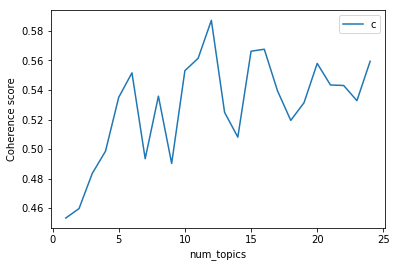

CPU times: user 4min 57s, sys: 28.4 s, total: 5min 26s
Wall time: 5min 20s


In [63]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=25)

In [67]:
print(c_v)
print(sorted(c_v.items(), key=operator.itemgetter(1), reverse=True)[0][0])

{0: 0.45339179550202069, 1: 0.45976001824810664, 2: 0.48353875308045463, 3: 0.498591190663071, 4: 0.53505638745288653, 5: 0.55160130572583055, 6: 0.4935118851988462, 7: 0.53584008054360577, 8: 0.49031243457702889, 9: 0.5530901622372455, 10: 0.56145128896048535, 11: 0.58714553255414581, 12: 0.52486810527802841, 13: 0.50809748956926548, 14: 0.56624916270803993, 15: 0.56758982019001059, 16: 0.53941702736657526, 17: 0.51944448005651067, 18: 0.53137507258154149, 19: 0.55800093908063952, 20: 0.54340438054408491, 21: 0.54306344496117365, 22: 0.53279476511547574, 23: 0.55944813428995599}
11


In [68]:
pyLDAvis.gensim.prepare(lmlist[sorted(c_v.items(), key=operator.itemgetter(1), reverse=True)[0][0]], corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      15.593189        1       1  0.037568  0.004704
10     12.937517        1       2  0.020036 -0.024756
5      11.192822        1       3 -0.059331  0.032098
8      10.830755        1       4  0.053333  0.006389
0       8.510518        1       5  0.055011  0.052193
9       8.224192        1       6 -0.044013 -0.036612
7       7.372090        1       7  0.011594 -0.028947
1       6.625948        1       8  0.038793 -0.011915
2       5.625803        1       9 -0.025376  0.011555
11      5.281995        1      10 -0.070621  0.013523
4       4.461802        1      11  0.018133 -0.022417
6       3.343369        1      12 -0.035127  0.004186, topic_info=      Category         Freq              Term        Total  loglift  logprob
term                                                                        
589    Default  3297.000000               art  3297.000000  30.0000  30.0000
17709  Default   888.000000     uniformização   888.000000  29.0000  29.0000
4477   Default   822.000000             turma   822.000000  28.0000  28.0000
104    Default  2050.000000              ltda  2050.000000  27.0000  27.0000
233    Default  1337.000000               www  1337.000000  26.0000  26.0000
96     Default  1710.000000              item  1710.000000  25.0000  25.0000
1659   Default   923.000000            código   923.000000  24.0000  24.0000
410    Default   698.000000             parte   698.000000  23.0000  23.0000
6      Default  2084.000000           federal  2084.000000  22.0000  22.0000
234    Default  1166.000000               gov  1166.000000  21.0000  21.0000
4741   Default   599.000000               adv   599.000000  20.0000  20.0000
4735   Default   261.000000              ipro   261.000000  19.0000  19.0000
16032  Default   237.000000               fts   237.000000  18.0000  18.0000
344    Default  1288.000000         contratar  1288.000000  17.0000  17.0000
3924   Default   638.000000              proc   638.000000  16.0000  16.0000
256    Default   519.000000          site_www   519.000000  15.0000  15.0000
6604   Default   574.000000        requerente   574.000000  14.0000  14.0000
257    Default   378.000000    comprasnet_gov   378.000000  13.0000  13.0000
18069  Default   461.000000            agravo   461.000000  12.0000  12.0000
394    Default  2315.000000             valor  2315.000000  11.0000  11.0000
239    Default   588.000000        comprasnet   588.000000  10.0000  10.0000
337    Default  1086.000000          contrato  1086.000000   9.0000   9.0000
5342   Default   463.000000         incidente   463.000000   8.0000   8.0000
28     Default  1315.000000          publicar  1315.000000   7.0000   7.0000
238    Default   888.000000              site   888.000000   6.0000   6.0000
391    Default  2130.000000               lei  2130.000000   5.0000   5.0000
236    Default   816.000000            propor   816.000000   4.0000   4.0000
1203   Default   657.000000             siape   657.000000   3.0000   3.0000
4859   Default   678.000000           decisão   678.000000   2.0000   2.0000
55     Default  3190.000000          processo  3190.000000   1.0000   1.0000
...        ...          ...               ...          ...      ...      ...
8109   Topic12    17.281620  juizado_especial   192.376280   0.9884  -6.7240
427    Topic12    42.294893           recurso   894.887853   0.3462  -5.8290
3924   Topic12    34.503951              proc   638.191089   0.4806  -6.0326
211    Topic12    56.087383           serviço  1507.498753   0.1069  -5.5468
1940   Topic12    16.374517            efeito   184.548571   0.9760  -6.7780
580    Topic12    29.336024            número   530.569748   0.5031  -6.1949
6      Topic12    62.284875           federal  2084.019662  -0.1121  -5.4420
1228   Topic12    24.793371         relatório   409.354661   0.5942  -6.3631
5342   Topic12    26.354278         incident

/media/discoD/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


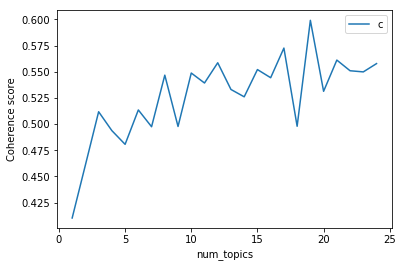

CPU times: user 3min 47s, sys: 9.62 s, total: 3min 56s
Wall time: 4min 16s


In [69]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary_filtered, corpus=corpus_filtered, texts=train_texts, limit=25)

In [71]:
print(c_v)
print(sorted(c_v.items(), key=operator.itemgetter(1), reverse=True)[0][0])
pyLDAvis.gensim.prepare(lmlist[sorted(c_v.items(), key=operator.itemgetter(1), reverse=True)[0][0]], corpus_filtered, dictionary_filtered)

{0: 0.41035927907250913, 1: 0.46093644691209118, 2: 0.51177747526663153, 3: 0.49375148748544218, 4: 0.48067385740298363, 5: 0.51349006758227378, 6: 0.49747281872569543, 7: 0.54669667617709161, 8: 0.49772471345661073, 9: 0.54872640906304715, 10: 0.53921368853885032, 11: 0.55852982984109001, 12: 0.53303247852220914, 13: 0.52602763502703387, 14: 0.55203572502128007, 15: 0.54425164773909984, 16: 0.57254704510380994, 17: 0.49791997085614448, 18: 0.59901722839556126, 19: 0.53128054208746278, 20: 0.56108379142957143, 21: 0.55090581366797342, 22: 0.54981089437012276, 23: 0.55772032930260285}
18


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      11.359927        1       1  0.000304  0.033858
10     11.245788        1       2  0.079002  0.081392
17      8.798475        1       3 -0.104924  0.007733
8       8.339230        1       4 -0.013342  0.001757
9       8.085767        1       5  0.069392 -0.033093
13      6.977408        1       6 -0.050719  0.024485
15      5.901448        1       7 -0.035346  0.005998
7       5.454372        1       8 -0.000406  0.041581
4       4.141544        1       9 -0.009137 -0.038885
5       3.889012        1      10  0.057237 -0.044278
0       3.612518        1      11  0.041302 -0.014186
11      3.356665        1      12  0.053649 -0.036352
12      3.330323        1      13  0.011570  0.016721
16      3.017919        1      14 -0.024820 -0.052733
6       2.912694        1      15  0.010926  0.010957
14      2.901187        1      16  0.029297  0.017425
18      2.664765        1      17 -0.063009  0.014753
2       2.093785        1      18 -0.007247  0.001368
1       1.917173        1      19 -0.043729 -0.038502, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
181   Default  1361.000000               www  1361.000000  30.0000  30.0000
182   Default  1185.000000               gov  1185.000000  29.0000  29.0000
87    Default  1659.000000              item  1659.000000  28.0000  28.0000
93    Default  1961.000000              ltda  1961.000000  27.0000  27.0000
26    Default  1732.000000            edital  1732.000000  26.0000  26.0000
1306  Default  1045.000000            código  1045.000000  25.0000  25.0000
186   Default   918.000000              site   918.000000  24.0000  24.0000
320   Default  2208.000000             valor  2208.000000  23.0000  23.0000
187   Default   582.000000        comprasnet   582.000000  22.0000  22.0000
184   Default   872.000000            propor   872.000000  21.0000  21.0000
6     Default  2346.000000           federal  2346.000000  20.0000  20.0000
481   Default  3773.000000               art  3773.000000  19.0000  19.0000
973   Default   789.000000             siape   789.000000  18.0000  18.0000
5514  Default   914.000000     uniformização   914.000000  17.0000  17.0000
278   Default  1678.000000              cnpj  1678.000000  16.0000  16.0000
279   Default  1174.000000         contratar  1174.000000  15.0000  15.0000
317   Default  2081.000000               lei  2081.000000  14.0000  14.0000
803   Default   283.000000              vaga   283.000000  13.0000  13.0000
53    Default  1105.000000            pregão  1105.000000  12.0000  12.0000
204   Default   520.000000          site_www   520.000000  11.0000  11.0000
2450  Default   834.000000             turma   834.000000  10.0000  10.0000
272   Default  1103.000000          contrato  1103.000000   9.0000   9.0000
89    Default  1278.000000           empresa  1278.000000   8.0000   8.0000
205   Default   374.000000    comprasnet_gov   374.000000   7.0000   7.0000
17    Default   802.000000             cargo   802.000000   6.0000   6.0000
172   Default  1282.000000             total  1282.000000   5.0000   5.0000
2638  Default   652.000000           decisão   652.000000   4.0000   4.0000
582   Default  1181.000000               ser  1181.000000   3.0000   3.0000
161   Default  1441.000000           serviço  1441.000000   2.0000   2.0000
316   Default  1185.000000             legal  1185.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
184   Topic19    40.282964            propor   872.251518   0.8792  -5.1861
2679  Topic19     5.129793          advogado    60.067885   1.4939  -7.2469
188   Topic19    28.614946          abertura   591.843974   0.9250  -5.5281
199   Topic19    17.522698    licitar_edital   308.127846   1.0873  -6.0185
190   Topic

In [40]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = get_best_model_by_topics(corpus=corpus, dictionary=dictionary, limit=50, texts=train_texts)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
        print('Melhores 5 modelos', top_topics[:5])
    return lm, top_topics

In [36]:
logging.disable(level=logging.INFO)

In [41]:
%%time
lm, top_topics = ret_top_model()

/home/pedro/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(5, 0.73169988798851271), (6, 0.71814579497499709), (3, 0.70086624055723812), (8, 0.69283338471343381), (16, 0.69105868521961733)]
Melhores 5 modelos [(1, 0.49153038747834793), (3, 0.44309482355181345), (0, 0.43110158015085565), (2, 0.40061933994606369), (4, 0.3110018845401829)]
Melhores 5 modelos [(4, 0.69710422491541302), (6, 0.69404891378665534), (8, 0.68678316062030731), (11, 0.67126412647894373), (5, 0.66767950243178775)]
Melhores 5 modelos [(0, 0.4885467543531396), (4, 0.41963539439982139), (2, 0.40061933994606358), (1, 0.35394331687792369), (3, 0.26719702343250151)]
Melhores 5 modelos [(6, 0.7830594008182562), (4, 0.71760172308584602), (11, 0.68522395617128784), (10, 0.67995211597921457), (5, 0.65671638010587141)]
Melhores 5 modelos [(1, 0.56142051842803409), (0, 0.44998082398855033), (3, 0.40061933994606358), (5, 0.36856048288168497), (2, 0.28381836930200388)]
Melhores 5 modelos [(8, 0.71590185433575781), (7, 0.71514098432779905), (6, 0.70801810375746099), (

KeyboardInterrupt: 

In [35]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[('proc_adv', 0.016016731893559868),
  ('incidente_uniformizacao', 0.012829814647509962),
  ('turma_recursal', 0.010936625295985868),
  ('inss_proc', 0.0091306983065047899),
  ('adv_procuradoria', 0.0090731010745261562),
  ('geral_federal', 0.0090731010745261562),
  ('parte_ora', 0.0089602210762516534),
  ('trata_agravo', 0.0087707625168775873),
  ('decisao_inadmitiu', 0.0086072663449699785),
  ('oab_requerido', 0.0083177163107341027)],
 [('comprasnet_gov', 0.027017224699846496),
  ('site_www', 0.02529700182894204),
  ('objeto_pregao', 0.018273239373618657),
  ('processo', 0.017400868819024449),
  ('abertura_propostas', 0.016551539482735283),
  ('propostas_partir', 0.016024489602518018),
  ('total_itens', 0.015450838906475283),
  ('edital_entrega', 0.01466498751076112),
  ('www_gov', 0.014505528771094914),
  ('licitados_edital', 0.01427815875000788)],
 [('codigo', 0.0098117947182114144),
  ('turma_recursal', 0.0092078500893413729),
  ('proc_adv', 0.0080897032116355461),
  ('incidente_

In [43]:
pyLDAvis.gensim.prepare(lm, corpus,       dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
4      5.002951        1       1 -0.390125 -0.036099
5      3.575705        1       2 -0.022637  0.180683
24     2.477793        1       3  0.070474 -0.029306
36     2.476030        1       4  0.018813  0.117893
72     2.272221        1       5  0.101304  0.005740
29     2.040274        1       6  0.096014 -0.055481
10     2.015970        1       7  0.034471 -0.017698
33     1.997512        1       8 -0.352434 -0.010864
76     1.812089        1       9  0.034875  0.042069
48     1.639230        1      10 -0.290535  0.037545
96     1.590694        1      11  0.071052 -0.017431
13     1.546939        1      12 -0.055480  0.005160
20     1.542378        1      13  0.061909  0.015141
78     1.526152        1      14  0.025200  0.002911
95     1.497165        1      15  0.064531 -0.012988
73     1.495734        1      16  0.016071  0.017601
85     1.432516        1      17  0.081672 -0.009027
8      1.396610        1      18 -0.280899  0.052196
46     1.390328        1      19  0.075234  0.148496
92     1.364753        1      20 -0.034771 -0.045221
63     1.350009        1      21  0.071802  0.019641
12     1.340904        1      22 -0.038872 -0.050807
15     1.314007        1      23  0.086328 -0.046006
83     1.296976        1      24  0.097731 -0.078775
55     1.276031        1      25 -0.172338  0.085062
31     1.249677        1      26  0.022550  0.039066
56     1.177628        1      27 -0.057871 -0.025176
90     1.165912        1      28  0.072910 -0.068320
47     1.158943        1      29  0.026099  0.115509
93     1.130407        1      30 -0.024427 -0.090750
...         ...      ...     ...       ...       ...
17     0.623098        1      71  0.068399  0.061484
39     0.611907        1      72 -0.008856  0.020029
40     0.599354        1      73  0.052906 -0.105208
97     0.578776        1      74  0.077977 -0.023870
57     0.552933        1      75  0.028425 -0.049248
58     0.552239        1      76 -0.019148 -0.091558
70     0.544983        1      77  0.084248  0.049683
7      0.544079        1      78 -0.120277 -0.099871
77     0.536104        1      79  0.034853 -0.021374
61     0.533028        1      80 -0.009357  0.045906
52     0.527977        1      81  0.030299  0.061488
38     0.517422        1      82 -0.013804  0.082175
79     0.505000        1      83 -0.145423  0.083312
18     0.490175        1      84 -0.052268 -0.078556
66     0.482309        1      85 -0.008728  0.021974
2      0.469946        1      86  0.033046  0.041294
9      0.462770        1      87 -0.183742  0.020642
25     0.443844        1      88  0.042634 -0.040058
11     0.432519        1      89  0.052711 -0.026380
37     0.432399        1      90  0.054880 -0.002248
87     0.432293        1      91  0.083387 -0.016078
0      0.426041        1      92  0.040855 -0.068819
30     0.413210        1      93 -0.041688 -0.027159
75     0.407997        1      94 -0.009008 -0.066735
91     0.401531        1      95  0.000840 -0.051953
82     0.396238        1      96  0.009260  0.087013
89     0.388531        1      97  0.039328 -0.077704
35     0.378135        1      98  0.045841  0.014267
32     0.285215        1      99  0.008807  0.011213
81     0.260842        1     100 -0.028100 -0.032002

[100 rows x 5 columns], topic_info=       Category         Freq                        Term        Total  \
term                                                                    
13572   Default   435.000000                  vigor_data   435.000000   
7919    Default   304.000000              quadro_pessoal   304.000000   
63      Default  1011.000000                        item  1011.000000   
583     Default  1776.000000                         art  1776.000000   
2767    Default   637.000000                      codigo   637.000000   
14098   Default   254.000000                 resolve_art   254.000000   
6561    De